In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models


In [17]:
DATASET_PATH = "/home/zoiba/fun_projects/dlfiles/alzheimers_code/Alzheimer_dataset/AugmentedAlzheimerDataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.
Dataset Information:
Number of classes: 4
Class names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

Analyzing class distribution...


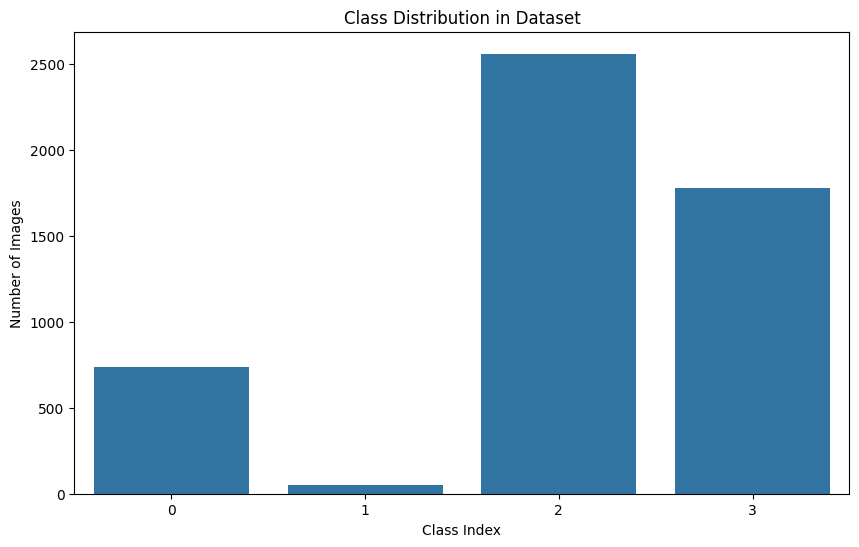

2025-06-04 23:47:41.205325: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


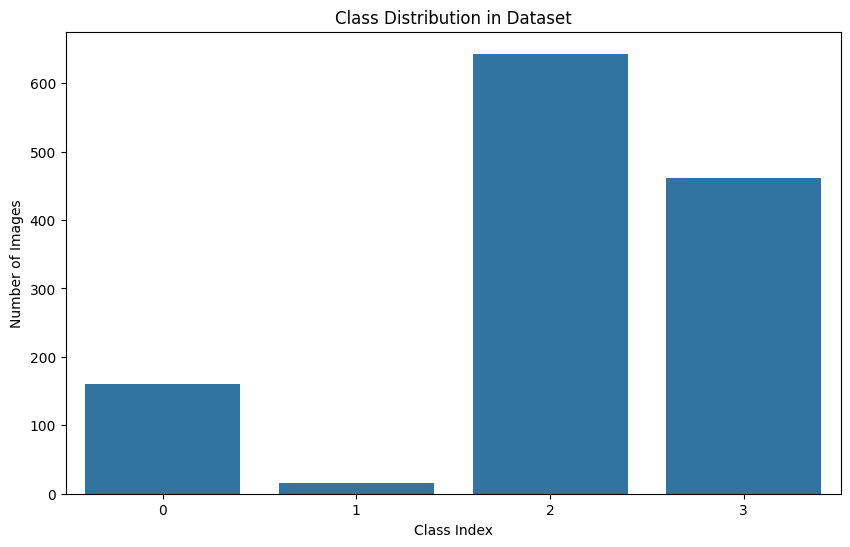


Visualizing sample images...


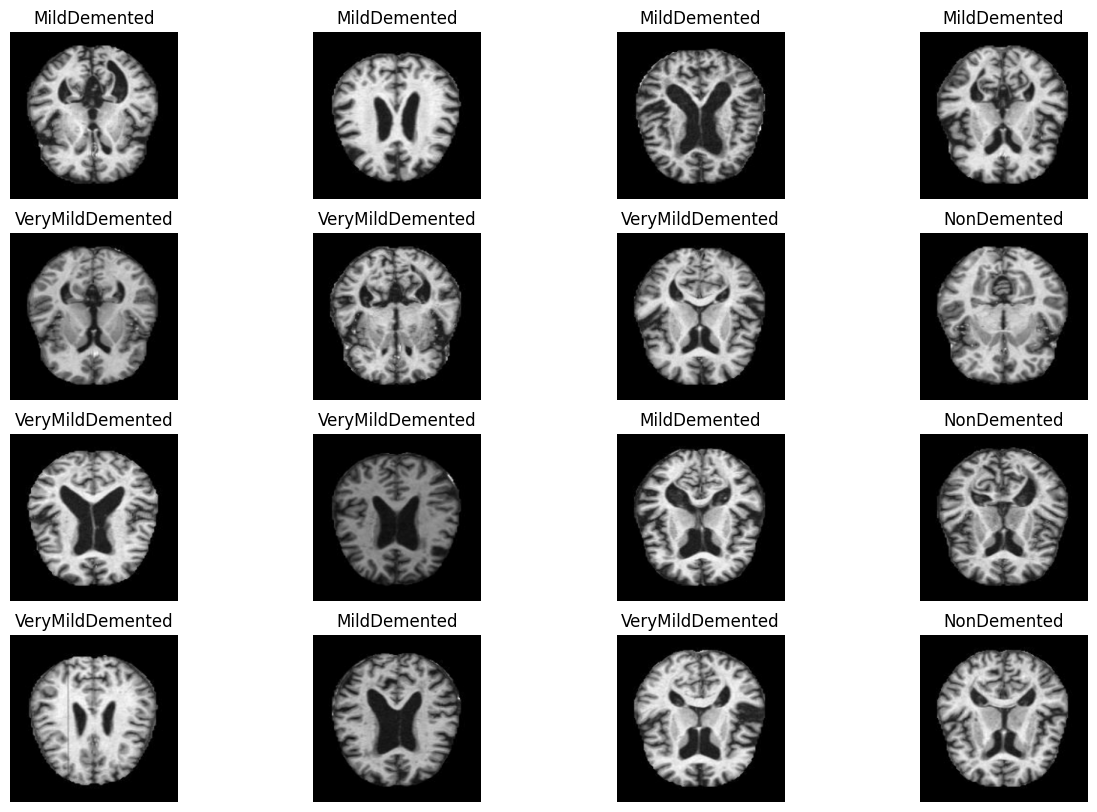


Analyzing image statistics...
Image Statistics:
Mean RGB values: [72.46498 72.46498 72.46498]
Std RGB values: [84.14661 84.14661 84.14661]
Min pixel value: 0.0
Max pixel value: 254.8278045654297


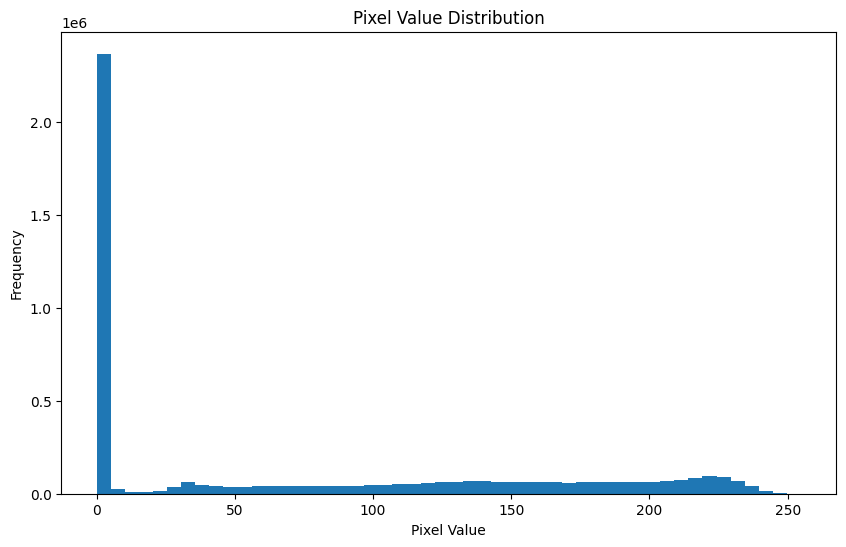

In [18]:
DATASET_PATH = "/home/zoiba/fun_projects/dlfiles/alzheimers_code/Alzheimer_dataset/OriginalDataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_dataset():
    """Load the dataset and return train and validation datasets"""
    train_ds = image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    val_ds = image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    return train_ds, val_ds

def analyze_class_distribution(dataset):
    """Analyze and plot class distribution"""
    class_counts = Counter()
    for images, labels in dataset:
        for label in labels:
            class_counts[label.numpy()] += 1
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Class Distribution in Dataset')
    plt.xlabel('Class Index')
    plt.ylabel('Number of Images')
    plt.show()
    
    return class_counts

def visualize_sample_images(dataset, class_names):
    """Display sample images from each class"""
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        for i in range(min(16, len(images))):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

def analyze_image_statistics(dataset):
    """Analyze basic image statistics"""
    all_images = []
    for images, _ in dataset.take(1):
        all_images.extend(images.numpy())
    
    all_images = np.array(all_images)
    
    # Calculate statistics
    mean = np.mean(all_images, axis=(0, 1, 2))
    std = np.std(all_images, axis=(0, 1, 2))
    min_val = np.min(all_images)
    max_val = np.max(all_images)
    
    print(f"Image Statistics:")
    print(f"Mean RGB values: {mean}")
    print(f"Std RGB values: {std}")
    print(f"Min pixel value: {min_val}")
    print(f"Max pixel value: {max_val}")
    
    # Plot pixel value distribution
    plt.figure(figsize=(10, 6))
    plt.hist(all_images.ravel(), bins=50)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

def main():
    # Load dataset
    train_ds, val_ds = load_dataset()
    class_names = train_ds.class_names
    
    print(f"Dataset Information:")
    print(f"Number of classes: {len(class_names)}")
    print(f"Class names: {class_names}")
    
    # Analyze class distribution
    print("\nAnalyzing class distribution...")
    train_class_counts = analyze_class_distribution(train_ds)
    val_class_counts = analyze_class_distribution(val_ds)
    
    # Visualize sample images
    print("\nVisualizing sample images...")
    visualize_sample_images(train_ds, class_names)
    
    # Analyze image statistics
    print("\nAnalyzing image statistics...")
    analyze_image_statistics(train_ds)

if __name__ == "__main__":
    main()

In [19]:
def build_resnet50_model(num_classes):
    base_model = tf.keras.applications.ResNet50(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_efficientnetv2_model(num_classes):
    base_model = tf.keras.applications.EfficientNetV2B0(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(model, train_ds, val_ds, epochs=5):
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    val_acc = history.history['val_accuracy'][-1]
    return model, val_acc

def compare_models(results):
    print("Model Comparison:")
    for name, acc in results.items():
        print(f"{name}: {acc:.4f}")

In [20]:
if __name__ == "__main__":
    resnet50_model = build_resnet50_model(num_classes)
    effnet_model = build_efficientnetv2_model(num_classes)

    resnet_model, cnn_acc = train_and_evaluate(cnn_model, train_ds, val_ds)
    effnet_model, effnet_acc = train_and_evaluate(effnet_model, train_ds, val_ds)

    results = {
        "ResNet50": cnn_acc,
        "EfficientNetV2": effnet_acc,
    }
    compare_models(results)
    # XAI, error analysis, and reporting as before

Epoch 1/5
849/850 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6053 - loss: 0.8934  

2025-06-04 23:50:16.154508: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-04 23:50:16.877652: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6054 - loss: 0.8933

2025-06-04 23:51:00.806401: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[12,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-04 23:51:01.381792: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[12,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

850/850 ━━━━━━━━━━━━━━━━━━━━ 198s 233ms/step - accuracy: 0.6054 - loss: 0.8932 - val_accuracy: 0.6738 - val_loss: 0.7044
Epoch 2/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 209s 246ms/step - accuracy: 0.6806 - loss: 0.7201 - val_accuracy: 0.7256 - val_loss: 0.6112
Epoch 3/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 195s 229ms/step - accuracy: 0.6990 - loss: 0.6688 - val_accuracy: 0.7197 - val_loss: 0.6322
Epoch 4/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 334s 393ms/step - accuracy: 0.7143 - loss: 0.6412 - val_accuracy: 0.7284 - val_loss: 0.5883
Epoch 5/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 649s 763ms/step - accuracy: 0.7285 - loss: 0.6072 - val_accuracy: 0.7513 - val_loss: 0.5623
Epoch 1/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 337s 331ms/step - accuracy: 0.4860 - loss: 1.1303 - val_accuracy: 0.6458 - val_loss: 0.7943
Epoch 2/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 232s 273ms/step - accuracy: 0.6295 - loss: 0.8314 - val_accuracy: 0.6558 - val_loss: 0.7529
Epoch 3/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 231s 272ms/step - accuracy: 0.6449 - loss: 0.7712 - va

In [21]:
# Improved model building and training for Alzheimer's classification
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = (224, 224)

# Data Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def build_resnet50_model(num_classes):
    base_model = tf.keras.applications.ResNet50(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_efficientnetv2_model(num_classes):
    base_model = tf.keras.applications.EfficientNetV2B0(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_and_evaluate(model, train_ds, val_ds, epochs=10):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])
    val_acc = history.history['val_accuracy'][-1]
    return model, val_acc

def compare_models(results):
    print("Model Comparison:")
    for name, acc in results.items():
        print(f"{name}: {acc:.4f}")

# Use the improved functions in main training script


Found 6400 files belonging to 4 classes.
Using 1280 files for validation.
Class names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


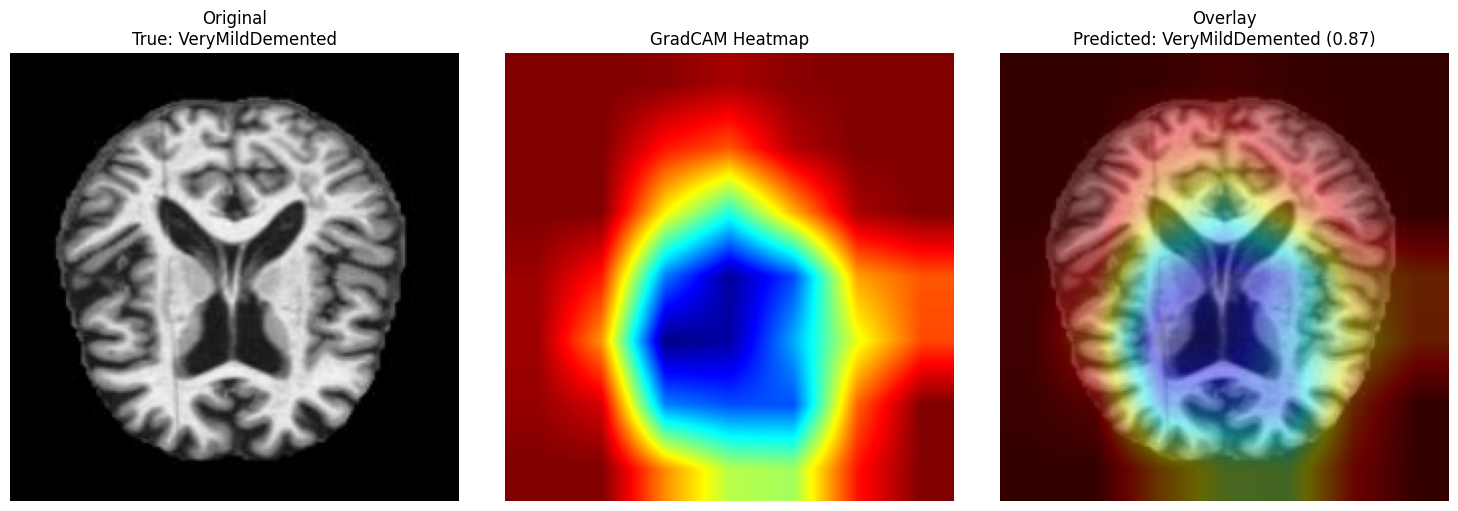


Prediction Details:
True class: VeryMildDemented
Predicted class: VeryMildDemented
Confidence: 0.87

Class probabilities:
MildDemented: 0.03
ModerateDemented: 0.02
NonDemented: 0.09
VeryMildDemented: 0.87


In [25]:
# Updated: GradCAM-compatible Functional API ResNet50 model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import ResNet50

# Constants
DATASET_PATH = "/home/zoiba/fun_projects/dlfiles/alzheimers_code/Alzheimer_dataset/OriginalDataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = test_ds.class_names
print(f"Class names: {class_names}")

# Functional API for better GradCAM integration
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# GradCAM setup
for images, labels in test_ds.take(1):
    img_array = tf.expand_dims(images[0], 0)
    true_label = labels[0].numpy()

    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])

    # GradCAM model
    last_conv_layer = base_model.get_layer('conv5_block3_out')
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, pred_class]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    img = tf.cast(img_array[0], tf.uint8).numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f'Original\nTrue: {class_names[true_label]}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('GradCAM Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f'Overlay\nPredicted: {class_names[pred_class]} ({preds[0][pred_class]:.2f})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\nPrediction Details:")
    print(f"True class: {class_names[true_label]}")
    print(f"Predicted class: {class_names[pred_class]}")
    print(f"Confidence: {preds[0][pred_class]:.2f}")
    print("\nClass probabilities:")
    for i, (class_name, prob) in enumerate(zip(class_names, preds[0])):
        print(f"{class_name}: {prob:.2f}")


Found 6400 files belonging to 4 classes.
Using 1280 files for validation.
Class names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


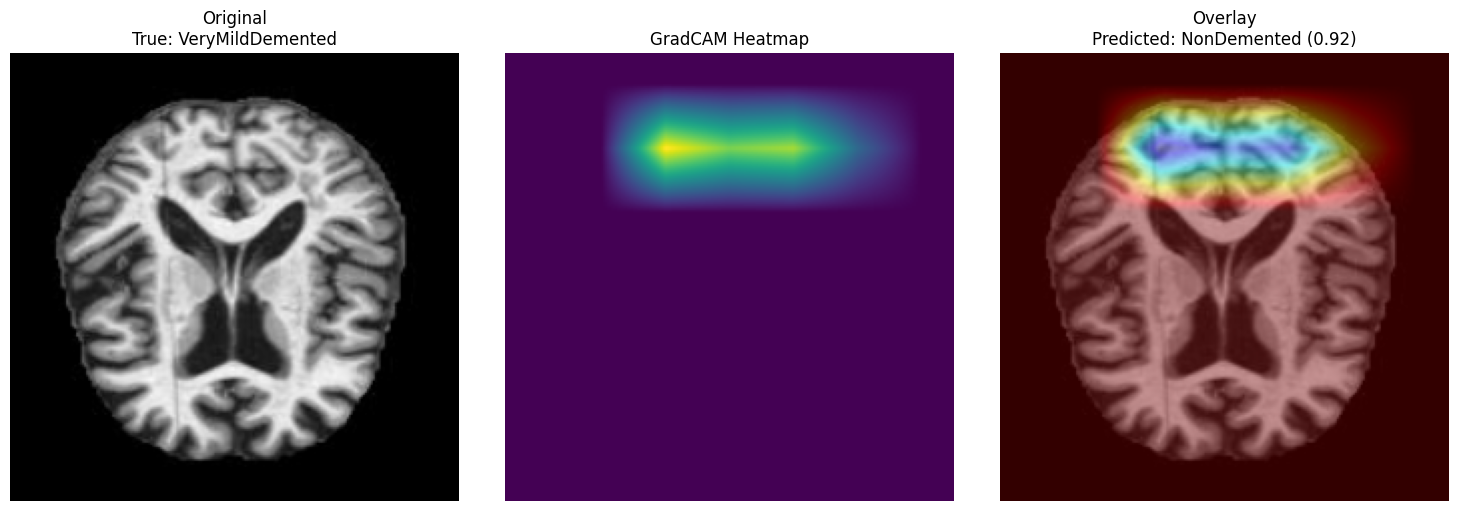

Prediction probabilities:
MildDemented: 0.02
ModerateDemented: 0.03
NonDemented: 0.92
VeryMildDemented: 0.03

------------------------------------------------------------



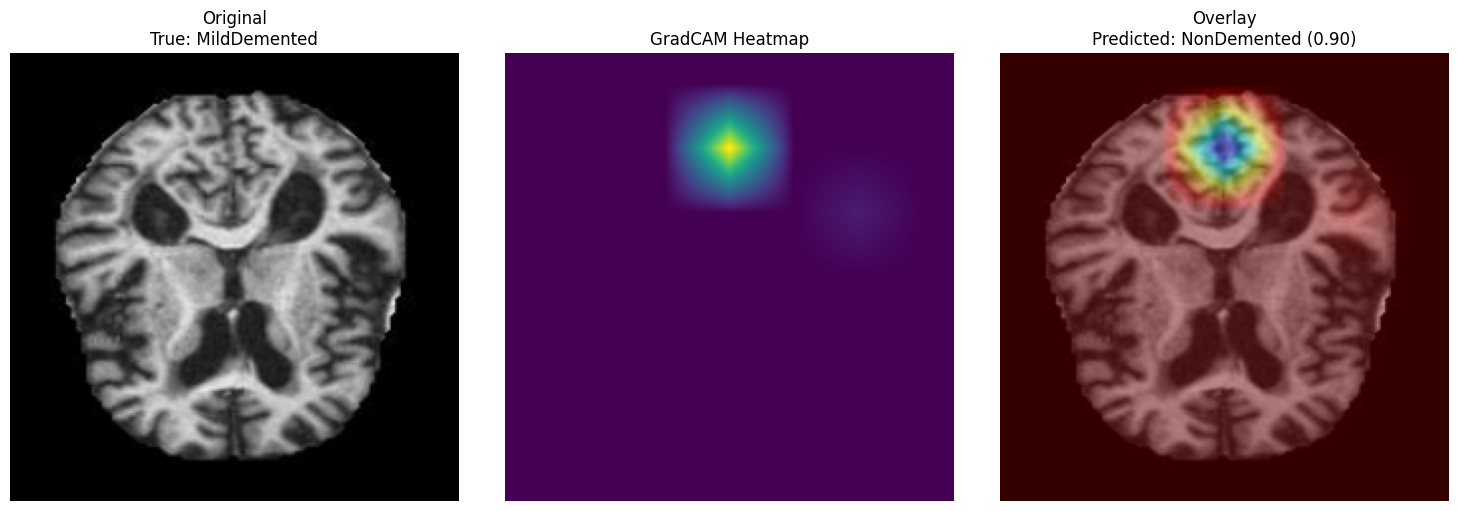

Prediction probabilities:
MildDemented: 0.02
ModerateDemented: 0.06
NonDemented: 0.90
VeryMildDemented: 0.02

------------------------------------------------------------



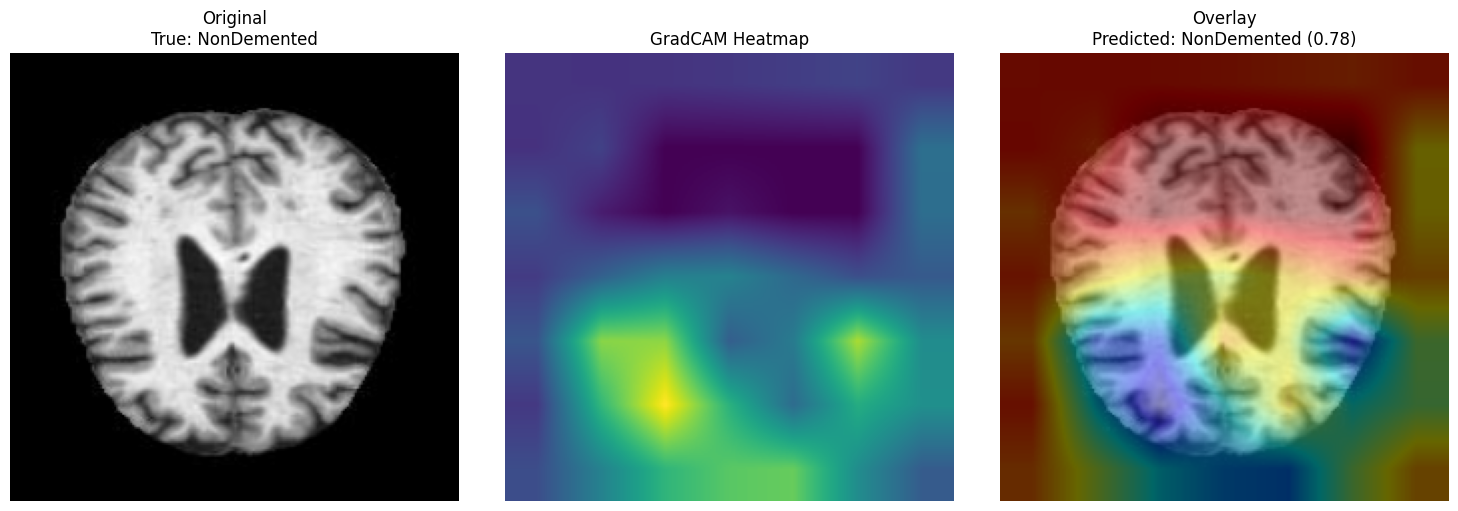

Prediction probabilities:
MildDemented: 0.02
ModerateDemented: 0.16
NonDemented: 0.78
VeryMildDemented: 0.05

------------------------------------------------------------



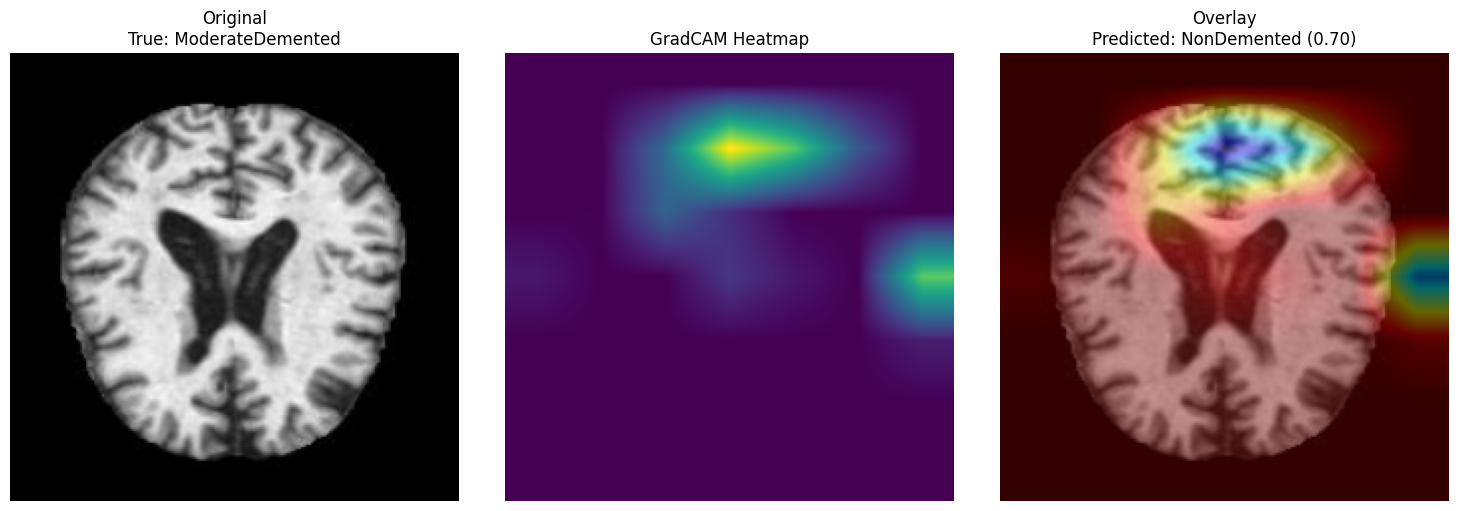

Prediction probabilities:
MildDemented: 0.11
ModerateDemented: 0.14
NonDemented: 0.70
VeryMildDemented: 0.05

------------------------------------------------------------



In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import ResNet50

# Config
DATASET_PATH = "/home/zoiba/fun_projects/dlfiles/alzheimers_code/Alzheimer_dataset/OriginalDataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = test_ds.class_names
print(f"Class names: {class_names}")

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Collect one image per class
selected_images = {}
for images, labels in test_ds:
    for img, label in zip(images, labels):
        label_val = int(label.numpy())
        if label_val not in selected_images:
            selected_images[label_val] = img
        if len(selected_images) == len(class_names):
            break
    if len(selected_images) == len(class_names):
        break

# GradCAM function
def compute_gradcam(image, model, base_model, class_index):
    img_array = tf.expand_dims(image, 0)
    preds = model(img_array)
    pred_class = np.argmax(preds[0])
    last_conv_layer = base_model.get_layer('conv5_block3_out')
    grad_model = tf.keras.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap, preds.numpy()[0]

# Visualize each class
for label_index, img in selected_images.items():
    heatmap, probs = compute_gradcam(img, model, base_model, label_index)
    pred_index = np.argmax(probs)
    img_np = img.numpy().astype(np.uint8)
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_np, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title(f"Original\nTrue: {class_names[label_index]}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized)
    plt.title("GradCAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed)
    plt.title(f"Overlay\nPredicted: {class_names[pred_index]} ({probs[pred_index]:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Prediction probabilities:")
    for i, name in enumerate(class_names):
        print(f"{name}: {probs[i]:.2f}")
    print("\n" + "-"*60 + "\n")


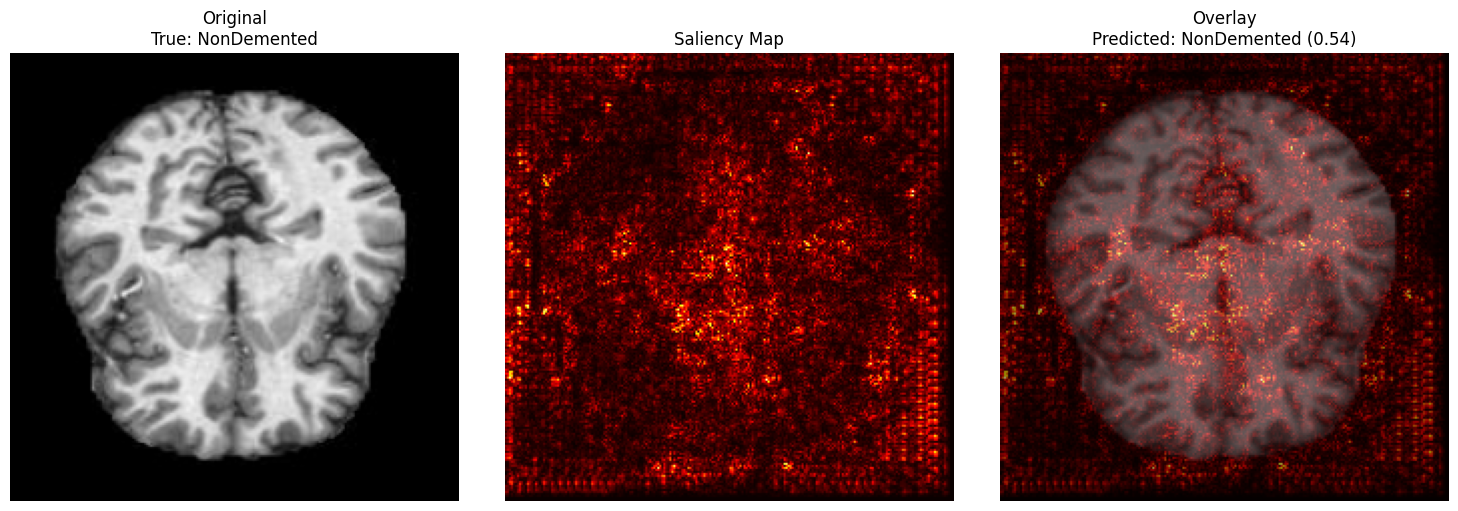


Prediction Details:
True class: NonDemented
Predicted class: NonDemented
Confidence: 0.54

Class probabilities:
MildDemented: 0.06
ModerateDemented: 0.23
NonDemented: 0.54
VeryMildDemented: 0.17


In [24]:
# Saliency Map Integration for Alzheimer Classification

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import ResNet50

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Saliency Map Function
def compute_saliency_map(model, image, true_label):
    image = tf.convert_to_tensor(image)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        preds = model(image)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, image)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    
    # Normalize
    saliency = saliency - tf.reduce_min(saliency)
    saliency = saliency / (tf.reduce_max(saliency) + 1e-8)
    return saliency.numpy(), class_idx.numpy(), preds.numpy()[0]

# Example usage from dataset
for images, labels in test_ds.take(1):
    img = images[0].numpy()
    true_label = labels[0].numpy()
    saliency_map, pred_class, class_probs = compute_saliency_map(model, img, true_label)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"Original\nTrue: {class_names[true_label]}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title("Saliency Map")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img.astype("uint8"))
    plt.imshow(saliency_map, cmap='hot', alpha=0.6)
    plt.title(f"Overlay\nPredicted: {class_names[pred_class]} ({class_probs[pred_class]:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("\nPrediction Details:")
    print(f"True class: {class_names[true_label]}")
    print(f"Predicted class: {class_names[pred_class]}")
    print(f"Confidence: {class_probs[pred_class]:.2f}")
    print("\nClass probabilities:")
    for i, (class_name, prob) in enumerate(zip(class_names, class_probs)):
        print(f"{class_name}: {prob:.2f}")
